# Data Preprocessing

Il dataset, prima di tutto, va opportunamente elaborato per occuparsi di eventuali dati duplicati o mancanti. Inoltre dovremo separare i dati per ottenere un training e un test set.
Gli step che seguiremo saranno i seguenti:
1. Caricare i dati
2. Gestire i dati mancanti
3. Eliminare le features ridondanti
4. Dividere il dataset in training e test set
5. Normalizzare e standardizzare i dati

### Definizione variabili

Per facilità d'utilizzo si esplicitano qui i `valori delle variabili` del modello.

In [123]:
# Lunghezza percentuale del dataset di allenamento, il test è definito di conseguenza
len_percentage_train = 80 / 100

numero_di_features = 2
output_CNN_1 = 20
kernel_size_1 = 2

lunni = True

### Librerie

Allo stesso modo si inseriscono qui tutte le `librerie usate` per il progetto

In [124]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Caricamento dei dati

Tramite `pandas` e il dataset fornito in .csv, carichiamo i dati all'interno di un dataset.

In [125]:
import sys
import pandas as pd

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    if lunni:
        fer2013 = pd.read_csv('/content/drive/My Drive//Università//Deep Learning//emotion-cnn//files//fer2013.csv') # LUNNI
    else:
        fer2013 = pd.read_csv('/content/drive/My Drive//Università//Deep Learning//emotion-cnn//files//fer2013.csv') # GIAN
else:
    fer2013 = pd.read_csv('files/fer2013.csv')
fer2013

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


### Eliminazione della colonna "Usage"

In [102]:
print(list(fer2013.columns))
fer2013 = fer2013.drop(['Usage'], axis=1)
print(list(fer2013.columns))

['emotion', 'pixels', 'Usage']
['emotion', 'pixels']


### Da stringa di Pixels a List

In [103]:
fer2013.pixels = fer2013.pixels.apply(lambda x: np.array(x.split(' ')).reshape(1, 48, 48).astype('float32') / 255)

### Salvo dataframe normalizzato

In [104]:
fer2013.to_pickle("files/fer_norm.pkl")

### Carico dataframe normalizzato

In [147]:
fer2013 = pd.read_pickle("files/fer_norm.pkl")
fer2013

,emotion,pixels
0,0,"[[[0.27450982, 0.3137255, 0.32156864, 0.282352..."
1,0,"[[[0.5921569, 0.5882353, 0.5764706, 0.60784316..."
2,2,"[[[0.90588236, 0.83137256, 0.6117647, 0.643137..."
3,4,"[[[0.09411765, 0.1254902, 0.14117648, 0.117647..."
4,6,"[[[0.015686275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
35882,6,"[[[0.19607843, 0.14117648, 0.06666667, 0.08627..."
35883,3,"[[[0.69803923, 0.68235296, 0.6745098, 0.678431..."
35884,0,"[[[0.06666667, 0.06666667, 0.0627451, 0.090196..."
35885,3,"[[[0.11764706, 0.10980392, 0.10980392, 0.11372..."


### Divisione del data set in training e test set

Si vuole dividere il data set in 2 parti:
1. Train set
2. Test set

In [148]:
train_set, test_set = np.split(fer2013, [ int(len_percentage_train * len(fer2013)) ] )
test_set.reset_index(inplace=True, drop=True)

print("Lunghezza percentuale di:")
print("train_set {:.0%}".format( len(train_set) / len(fer2013) ))
print("test_set {:.0%}".format( len(test_set) / len(fer2013) ))

Lunghezza percentuale di:
train_set 80%
test_set 20%


### Creazione tensori e dataloader

In [149]:
train_x, train_y = torch.tensor(train_set.pixels), torch.tensor(train_set.emotion)
test_x, test_y = torch.tensor(test_set.pixels), torch.tensor(test_set.emotion)

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, drop_last=True)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

### Mostrare le immagini

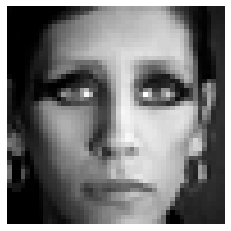

In [95]:
def show(img):
    img = img * 255
    plt.axis("off")
    plt.imshow(img, cmap = 'gray')

show(fer2013.pixels[4])

# Modello con CNN

### VGG16 Schema

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16.jpg" alt="drawing" width="500"/>

### Definizione del modello

In [154]:
class Emotion_CNN(torch.nn.Module):
    def __init__(self):
        super(Emotion_CNN, self).__init__()
    
        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(4),
            # Da guardare se inplace = True ha senso
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )
 
        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(4 * 12 * 12, 10)
        )
 
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

[Sito da cui ho preso il modello successivo](https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/)

In [ ]:
# class Net(Module):   
#     def __init__(self):
#         super(Net, self).__init__()
#
#         self.cnn_layers = Sequential(
#             # Defining a 2D convolution layer
#             Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(4),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=2, stride=2),
#             # Defining another 2D convolution layer
#             Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(4),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=2, stride=2),
#         )
# 
#         self.linear_layers = Sequential(
#             Linear(4 * 7 * 7, 10)
#         )
# 
#     # Defining the forward pass    
#     def forward(self, x):
#         x = self.cnn_layers(x)
#         x = x.view(x.size(0), -1)
#         x = self.linear_layers(x)
#         return x

### Istanza del modello

Qua Lunni dobbiamo fare attenzione a `impostare il device in base all'ambiente` (Colab o locale)

In [155]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = Emotion_CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
device

device(type='cpu')

### Definizione di Training e Validation

After building your model, you need to select a loss function (e.g. `cross entropy`), and an optimization module, along with a learning rate. Train and test your CNN model using the usual pipeline we have seen during the practical lessons.

In [158]:
train_losses = []
valid_losses = []

def Train(epoca):
    running_loss = .0
    
    model.train()

    # valori_previsti_lista = []
    # valori_veri_lista = []

    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        preds = model(inputs.float())
        # preds = torch.squeeze(preds)
        # labels = torch.squeeze(labels)

        # valori_veri_lista.append((labels.detach().numpy() * standard_scaler.scale_[2]) + standard_scaler.mean_[2])
        # valori_previsti_lista.append((preds.detach().numpy() * standard_scaler.scale_[2]) + standard_scaler.mean_[2])

        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    # confronto = pd.DataFrame(np.array([valori_veri_lista, valori_previsti_lista]).transpose(), index=list(range(len(valori_veri_lista))), columns=['veri', 'predetti'])
    # confronto.to_csv("files/training_epoch_" + str(epoca) + ".csv")

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().data.numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            # preds = torch.squeeze(preds)
            # labels = torch.squeeze(labels)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(test_loader)
        valid_losses.append(valid_loss.detach().cpu().data.numpy())
        print(f'valid_loss {valid_loss}')

### Allenamento e Validazione del modello

In [159]:
epochs = 10

for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train(epoch + 1)
    Valid()

epochs 1/10
train_loss 1.7124146223068237
valid_loss 1.7435275316238403
epochs 2/10
train_loss 1.6667674779891968
valid_loss 1.714720368385315
epochs 3/10


KeyboardInterrupt: 

### Visualizzazione grafico della loss

In [ ]:
loss_df = pd.DataFrame( {'Train Losses':train_losses, 'Valid Losses':valid_losses }, index=list(range(len(train_losses))) )

loss_df=loss_df.astype(float)

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")

### Salva stato del modello

In [ ]:
torch.save(model.state_dict(), 'files/saved_state_of_model.pth')

### Carica stato del modello

In [ ]:
model.load_state_dict(torch.load('files/saved_state_of_model.pth'))

# Predizione e valutazione del modello

### Classificazione di Test

### Valutazione del modello